In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import polyfit, poly1d
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splrep, splev
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import seaborn as sns
import kw
import kwgraph

In [2]:
dfs = kw.getdf_xlsx()

df_master = dfs['試験マスタ']
df_data = dfs['試験データ']

df =df_master.merge(df_data, on='test_id')

df['theoretical_power'] = df['capacity'] * df['total_head'] * 9.8 / 60
df['pump_eff'] = df['theoretical_power'] / df['shaft_power'] * 100

# データを'model'と'test_no'でグループ化し、それぞれのグループに対してグラフを作成します
models = df['model'].unique()
models

array(['AZ40F2.2', 'AZ40F3.7', 'AZ50F2.2', 'AZ50F3.7', 'AZ65F3.7'],
      dtype=object)

In [26]:
selected_models = [
   ['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7'],
   ['AZ65F3.7', 'AZ50F3.7'],
   ['AZ50F2.2'],
   ['AZ40F2.2', 'AZ65F3.7'],
]

['AZ65F3.7']
['AZ65F3.7']
['AZ65F3.7']
['AZ65F3.7', 'AZ50F3.7']
['AZ50F3.7']
['AZ50F3.7']
['AZ65F3.7', 'AZ50F3.7', 'AZ40F3.7']
['AZ40F3.7']
['AZ40F3.7']
['AZ65F3.7']
['AZ65F3.7']
['AZ65F3.7']
['AZ65F3.7', 'AZ50F3.7']
['AZ50F3.7']
['AZ50F3.7']
['AZ50F2.2']
['AZ50F2.2']
['AZ50F2.2']
['AZ40F2.2']
['AZ40F2.2']
['AZ40F2.2']
['AZ40F2.2', 'AZ65F3.7']
['AZ65F3.7']
['AZ65F3.7']


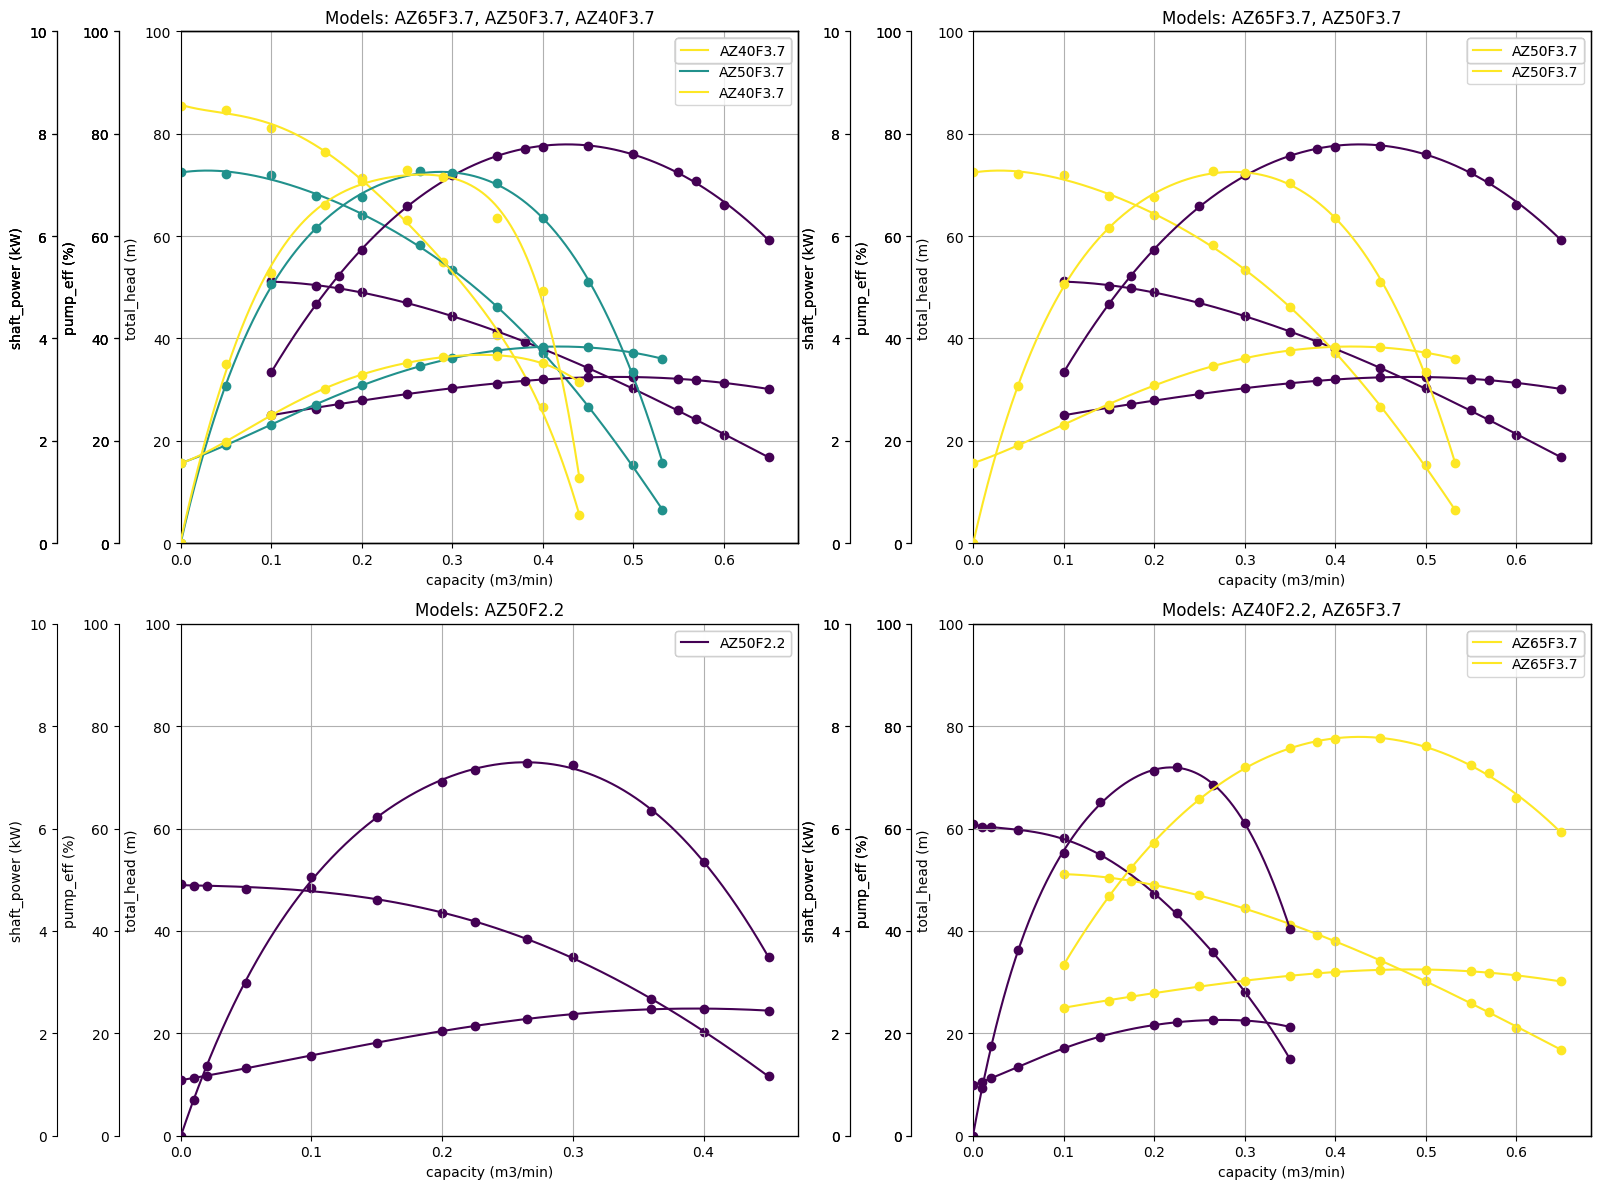

In [55]:
kwgraph.draw_plot4(df, selected_models,
                  y_axis_lims=[(0, 100), (0, 100), (0, 10)],
                  types_of_plot=["scatter", "polyfit"],
                #   types_of_plot=["polyfit"],
                  use_colormap=True,
                  )

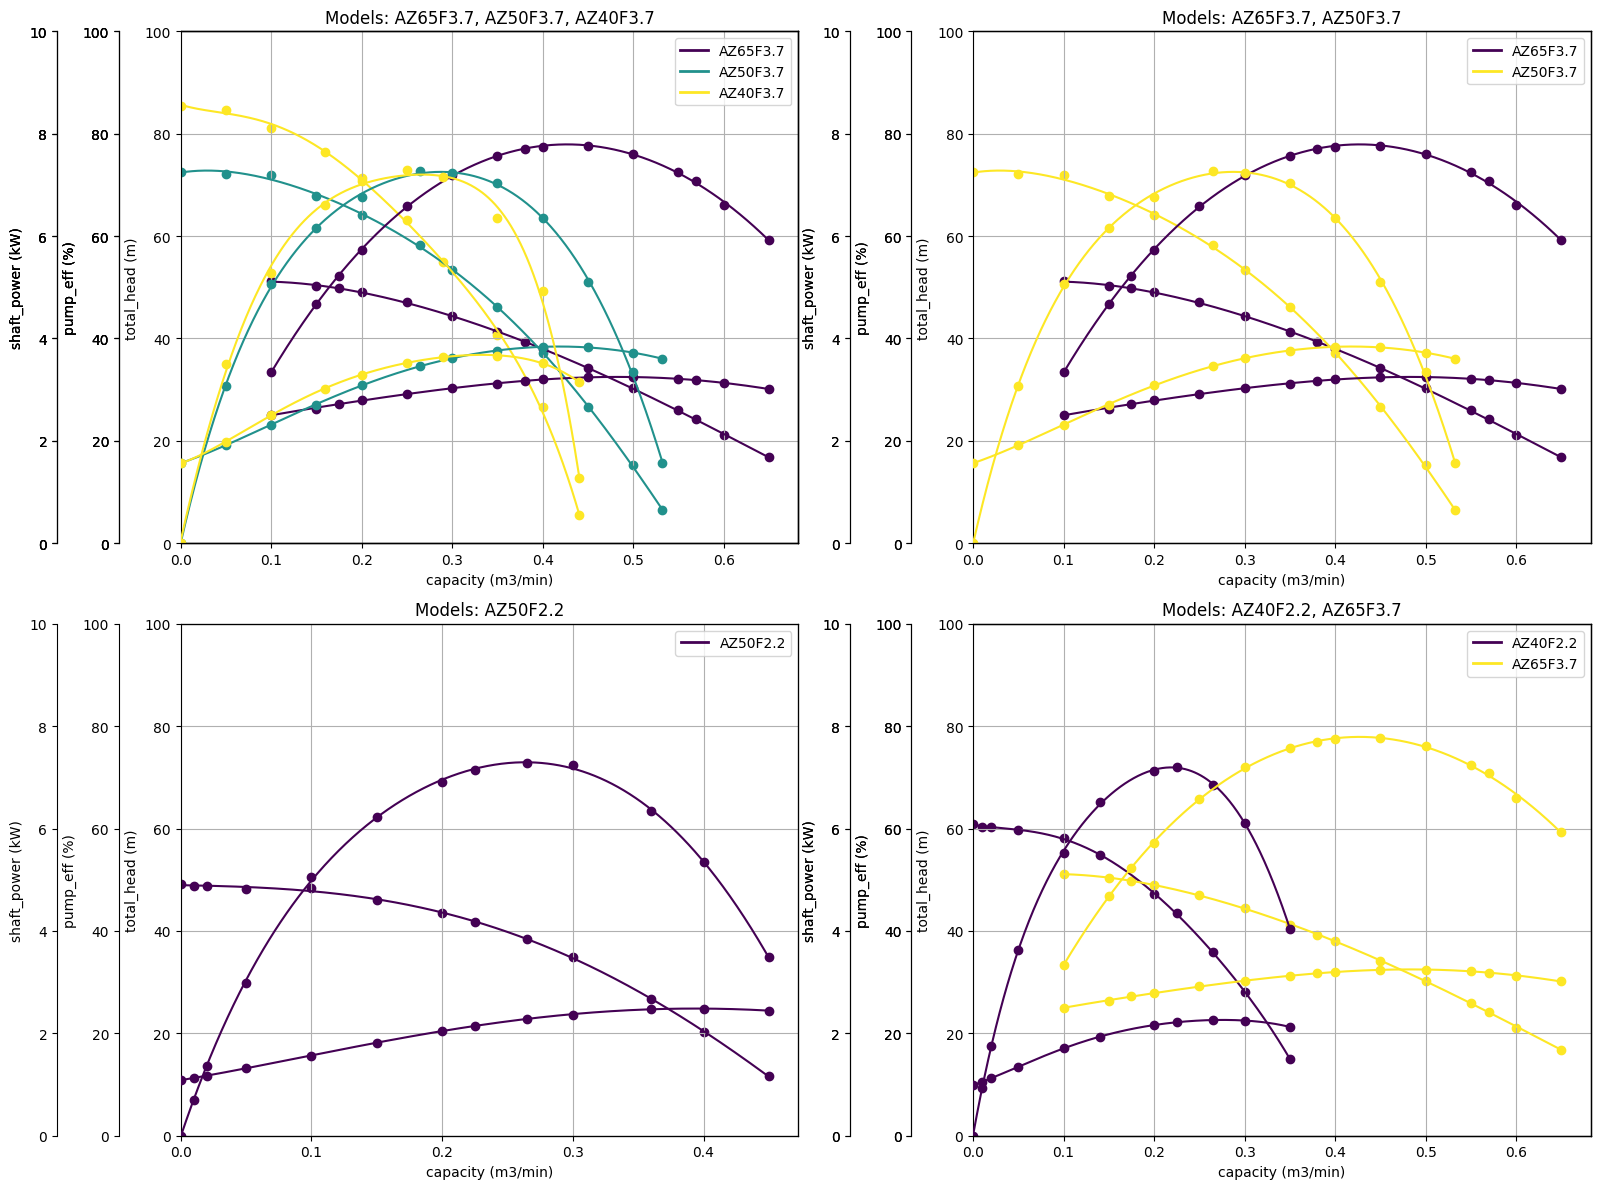

In [57]:
kwgraph.draw_plot4b(df, selected_models,
                  y_axis_lims=[(0, 100), (0, 100), (0, 10)],
                  types_of_plot=["scatter", "polyfit"],
                  use_colormap=True,
                  )

ここから下は不要

In [50]:
# 軸の設定
x_axis = 'capacity'
x_axis_unit = 'm3/min'
xlim_min = 0
xlim_max = None

y_axis1 = 'total_head'
y_axis_unit1 = 'm'

y_axis2 = 'pump_eff'
y_axis_unit2 = '%'

y_axis3 = 'shaft_power'
y_axis_unit3 = 'kW'

In [51]:
import matplotlib.cm as cm

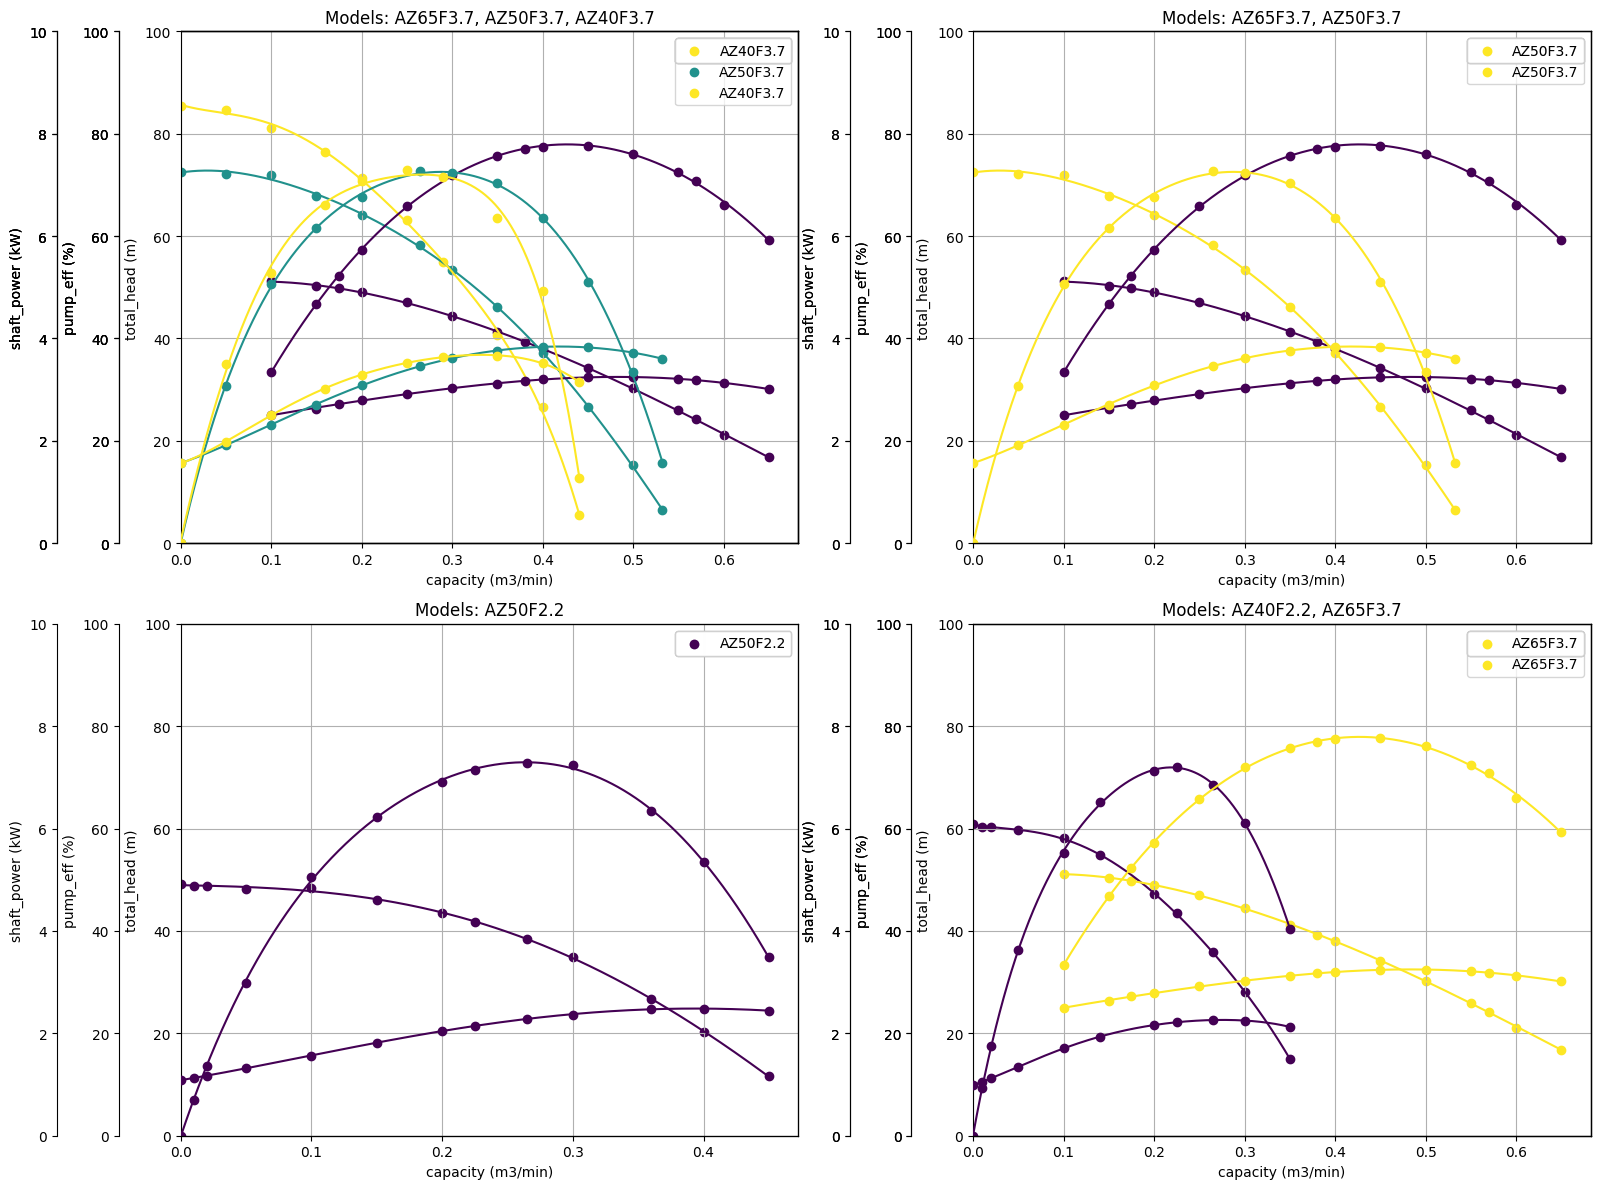

In [28]:
kwgraph.draw_plot5(df, selected_models,
                  y_axis_lims=[(0, 100), (0, 100), (0, 10)],
                  types_of_plot=["scatter", "polyfit"],
                  use_colormap=True,
                  )

## 暫定

In [52]:
def draw_plot4(
    df,
    selected_models,
    x_axis=x_axis,
    X_axis_unit=x_axis_unit,
    y_axes=[y_axis1, y_axis2, y_axis3],
    y_axis_units=[y_axis_unit1, y_axis_unit2, y_axis_unit3],
    y_axis_lims=[(0, None), (0, None), (0, None)],
    types_of_plot=["scatter", "polyfit"],
    polyfit_degree=5,
    num_rows=2,
    colormap="viridis",  # Added argument for colormap
    use_colormap=True,  # Added argument to switch between colormap and color list
):
    flattened_models = [model for sublist in selected_models for model in sublist]

    # 軸毎の色を指定
    axis_colors = ["k", "k", "k"]

    # モデルの数に基づいてサブプロットの列数を計算
    num_cols = len(selected_models) // num_rows
    if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
        num_cols += 1  # 列数を1つ増やす

    # Figureとarray of axesを作成
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
    axs = axs.ravel()

    for i, models in enumerate(selected_models):
        x_max = 0  # x_maxを初期化

        if use_colormap:  # If colormap is to be used
            cmap = cm.get_cmap(colormap, len(models))
            model_colors = iter([cmap(i) for i in range(cmap.N)])
        else:
            model_colors = itertools.cycle(["k", "r", "b"])  # cycleで無限リストを生成

        for model in models:
            color = next(model_colors)
            df_model = df[df["model"] == model]

            # 現在のモデルに対するxの最大値を取得
            x_max_model = df_model[x_axis].max()

            # これが現在のx_maxより大きければ、x_maxを更新
            if x_max_model > x_max:
                x_max = x_max_model

            # 現在のaxesを選択
            ax = axs[i]
            ax.set_xlabel(f"{x_axis} ({X_axis_unit})")
            ax.grid(True)

            # 複数のy軸をプロット
            for j, y_axis in enumerate(y_axes):
                y_axis_unit = y_axis_units[j]
                y_axis_lim = y_axis_lims[j]

                if j > 0:  # 2つ目以降のy軸の場合、新しいAxesを作成
                    ax = ax.twinx()

                    # Y軸の位置を調整
                    ax.spines["left"].set_position(("axes", -0.1 * j))  # 軸の位置を調整
                    ax.yaxis.set_label_position("left")  # ラベルの位置を調整
                    ax.yaxis.set_ticks_position("left")  # ティックの位置を調整

                ax.set_ylabel(f"{y_axis} ({y_axis_unit})", color=axis_colors[j])
                ax.set_ylim(y_axis_lim)

                # データ点のプロット
                if "scatter" in types_of_plot:
                    ax.scatter(df_model[x_axis], df_model[y_axis], color=color)

                # Polyfit
                if "polyfit" in types_of_plot:
                    poly_coeffs = polyfit(
                        df_model[x_axis], df_model[y_axis], deg=polyfit_degree
                    )
                    poly = np.poly1d(poly_coeffs)
                    xs = np.linspace(
                        df_model[x_axis].min(), df_model[x_axis].max(), 500
                    )
                    ax.plot(xs, poly(xs), color=color, label=model)

                # スプライン補間
                if "spline" in types_of_plot:
                    tck = splrep(df_model[x_axis], df_model[y_axis], k=3)
                    xs = np.linspace(
                        df_model[x_axis].min(), df_model[x_axis].max(), 500
                    )
                    ys = splev(xs, tck)
                    ax.plot(xs, ys, color=color, label=model)

                ax.tick_params(axis="y", labelcolor=axis_colors[j])
                ax.legend(loc="best")

        # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
        ax.set_xlim(0, x_max + x_max * 0.05)

        # モデルの数が多い場合、タイトルを簡略化
        if len(models) > 5:  # 5はタイトルが長くなりすぎると判断するモデル数の閾値
            ax.set_title(f"Number of Models: {len(models)}")
        else:
            ax.set_title(f'Models: {", ".join(models)}')

    # 使用しないサブプロットを削除
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()

## 関数

In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from numpy.polynomial.polynomial import polyfit
from matplotlib import cm

def plot_scatter(ax, df_model, x_axis, y_axis, color):
    ax.scatter(df_model[x_axis], df_model[y_axis], color=color)

def plot_polyfit(ax, df_model, x_axis, y_axis, color, polyfit_degree=5):
    poly_coeffs = polyfit(df_model[x_axis], df_model[y_axis], deg=polyfit_degree)
    poly = np.poly1d(poly_coeffs)
    xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
    ax.plot(xs, poly(xs), color=color)

def plot_spline(ax, df_model, x_axis, y_axis, color):
    tck = splrep(df_model[x_axis], df_model[y_axis], k=3)
    xs = np.linspace(df_model[x_axis].min(), df_model[x_axis].max(), 500)
    ys = splev(xs, tck)
    ax.plot(xs, ys, color=color)

def create_subplot(num_rows, num_cols):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
    return fig, axs.ravel()

def configure_axis(ax, x_axis, X_axis_unit, y_axis, y_axis_unit, y_axis_lim, axis_color):
    ax.set_xlabel(f"{x_axis} ({X_axis_unit})")
    ax.grid(True)
    ax.set_ylabel(f"{y_axis} ({y_axis_unit})", color=axis_color)
    ax.set_ylim(y_axis_lim)

def set_subplot_title(ax, models):
    if len(models) > 5:
        ax.set_title(f"Number of Models: {len(models)}")
    else:
        ax.set_title(f'Models: {", ".join(models)}')

def draw_plotx(
    df,
    selected_models,
    x_axis=x_axis,
    X_axis_unit=x_axis_unit,
    y_axes=[y_axis1, y_axis2, y_axis3],
    y_axis_units=[y_axis_unit1, y_axis_unit2, y_axis_unit3],
    y_axis_lims=[(0, None), (0, None), (0, None)],
    types_of_plot=["scatter"],
    polyfit_degree=5,
    num_rows=2,
    colormap="viridis",
    use_colormap=True,
):
    flattened_models = [model for sublist in selected_models for model in sublist]
    axis_colors = ["k", "k", "k"]
    num_cols = len(selected_models) // num_rows
    if len(selected_models) % num_rows != 0:
        num_cols += 1
    
    fig, axs = create_subplot(num_rows, num_cols)

    for i, models in enumerate(selected_models):
        x_max = 0
        
        if use_colormap:
            cmap = cm.get_cmap(colormap, len(models))
            model_colors = iter([cmap(i) for i in range(cmap.N)])
        else:
            model_colors = itertools.cycle(["k", "r", "b"])

        for model in models:
            color = next(model_colors)
            df_model = df[df["model"] == model]
            x_max_model = df_model[x_axis].max()
            if x_max_model > x_max:
                x_max = x_max_model

            ax = axs[i]
            configure_axis(ax, x_axis, X_axis_unit, y_axes[0], y_axis_units[0], y_axis_lims[0], axis_colors[0])

            for j, y_axis in enumerate(y_axes):
                if "scatter" in types_of_plot:
                    plot_scatter(ax, df_model, x_axis, y_axis, color)
                if "polyfit" in types_of_plot:
                    plot_polyfit(ax, df_model, x_axis, y_axis, color, polyfit_degree)
                if "spline" in types_of_plot:
                    plot_spline(ax, df_model, x_axis, y_axis, color)
                
                if j > 0:
                    ax = ax.twinx()
                    configure_axis(ax, x_axis, X_axis_unit, y_axes[j], y_axis_units[j], y_axis_lims[j], axis_colors[j])
                
                ax.tick_params(axis="y", labelcolor=axis_colors[j])
                ax.legend(loc="best")

            ax.set_xlim(0, x_max + x_max * 0.05)

            set_subplot_title(ax, models)

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()


In [41]:
def draw_plotx2(
    df,
    selected_models,
    x_axis=x_axis,
    X_axis_unit=x_axis_unit,
    y_axes=[y_axis1, y_axis2, y_axis3],
    y_axis_units=[y_axis_unit1, y_axis_unit2, y_axis_unit3],
    y_axis_lims=[(0, None), (0, None), (0, None)],
    types_of_plot=["scatter", "polyfit"],
    polyfit_degree=5,
    num_rows=2,
    colormap="viridis",  # Added argument for colormap
    use_colormap=True,  # Added argument to switch between colormap and color list
):
    flattened_models = [model for sublist in selected_models for model in sublist]

    # 軸毎の色を指定
    axis_colors = ["k", "k", "k"]

    # モデルの数に基づいてサブプロットの列数を計算
    num_cols = len(selected_models) // num_rows
    if len(selected_models) % num_rows != 0:  # モデルの数が行数で割り切れない場合
        num_cols += 1  # 列数を1つ増やす

    # Figureとarray of axesを作成
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))
    axs = axs.ravel()

    for i, models in enumerate(selected_models):
        x_max = 0  # x_maxを初期化

        if use_colormap:  # If colormap is to be used
            cmap = cm.get_cmap(colormap, len(models))
            model_colors = iter([cmap(i) for i in range(cmap.N)])
        else:
            model_colors = itertools.cycle(["k", "r", "b"])  # cycleで無限リストを生成

        for model in models:
            color = next(model_colors)
            df_model = df[df["model"] == model]

            # 現在のモデルに対するxの最大値を取得
            x_max_model = df_model[x_axis].max()

            # これが現在のx_maxより大きければ、x_maxを更新
            if x_max_model > x_max:
                x_max = x_max_model

            # 現在のaxesを選択
            ax = axs[i]
            ax.set_xlabel(f"{x_axis} ({X_axis_unit})")
            ax.grid(True)

            # 複数のy軸をプロット
            for j, y_axis in enumerate(y_axes):
                y_axis_unit = y_axis_units[j]
                y_axis_lim = y_axis_lims[j]

                if j > 0:  # 2つ目以降のy軸の場合、新しいAxesを作成
                    ax = ax.twinx()

                    # Y軸の位置を調整
                    ax.spines["left"].set_position(("axes", -0.1 * j))  # 軸の位置を調整
                    ax.yaxis.set_label_position("left")  # ラベルの位置を調整
                    ax.yaxis.set_ticks_position("left")  # ティックの位置を調整

                ax.set_ylabel(f"{y_axis} ({y_axis_unit})", color=axis_colors[j])
                ax.set_ylim(y_axis_lim)

                if "scatter" in types_of_plot:
                    plot_scatter(ax, df_model, x_axis, y_axis, color)
                if "polyfit" in types_of_plot:
                    plot_polyfit(ax, df_model, x_axis, y_axis, color, polyfit_degree)
                if "spline" in types_of_plot:
                    plot_spline(ax, df_model, x_axis, y_axis, color)

                ax.tick_params(axis="y", labelcolor=axis_colors[j])
                ax.legend(loc="best")

        # すべてのモデルについてループが終わった後に、このサブプロットのxlimを設定
        ax.set_xlim(0, x_max + x_max * 0.05)

        # モデルの数が多い場合、タイトルを簡略化
        if len(models) > 5:  # 5はタイトルが長くなりすぎると判断するモデル数の閾値
            ax.set_title(f"Number of Models: {len(models)}")
        else:
            ax.set_title(f'Models: {", ".join(models)}')

    # 使用しないサブプロットを削除
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()